In [1]:
import torch
from network import NAF
from sound_loader import sound_samples
import utils.irutilities as irutil
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt
import math

path = Path('mesh_rir/S32-M441_npy/')
print('Loading IRs ...')
posMic, posSrc, ir = irutil.loadIR(path)

samplerate = 48000

s = 0
m = 32
sample = ir[s,m,:]
src = posSrc[s]
mic = posMic[m]

Loading IRs ...


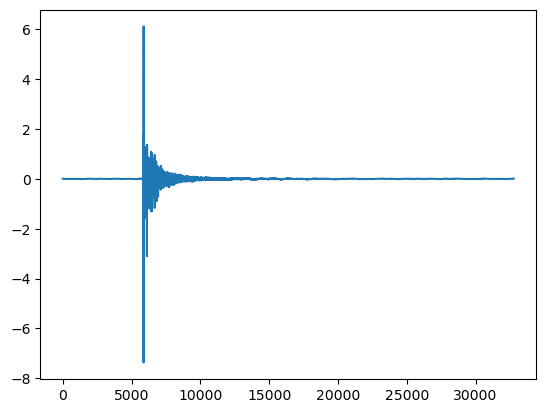

(2, 257, 257)
(257, 257)
(257, 257) (257, 257)


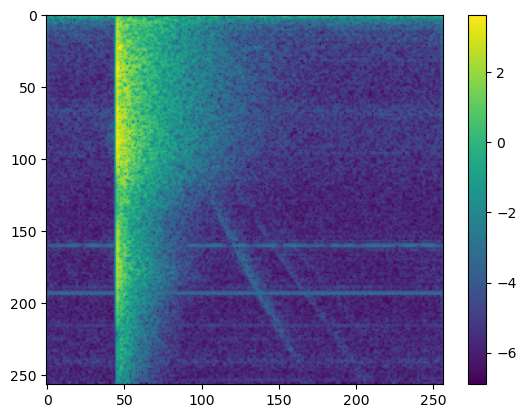

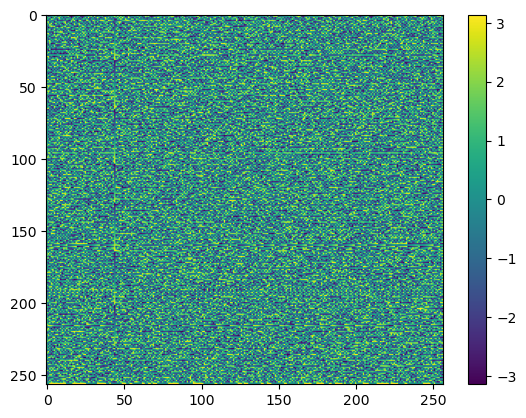

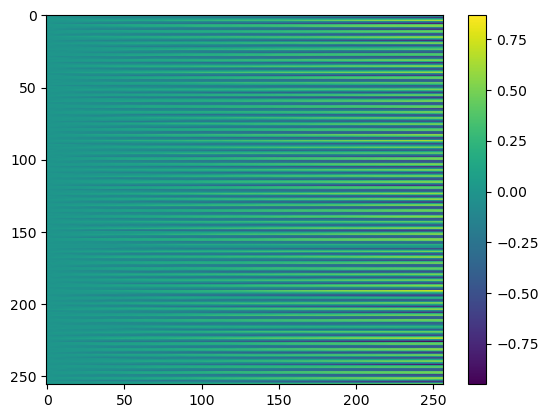

ValueError: operands could not be broadcast together with shapes (257,257) (256,258) 

In [3]:
# plot sound
plt.figure()
plt.plot(sample)
plt.show()

n_fft = 512
hop = n_fft // 4

def if_compute(arg):
    unwrapped_angle = np.unwrap(arg).astype(np.single)
    return np.diff(unwrapped_angle, n=1, axis=0)


transformed_data = np.array([librosa.stft(sample,n_fft=n_fft, hop_length=hop), librosa.stft(sample,n_fft=n_fft, hop_length=hop)])
print(transformed_data.shape)
transformed_data = transformed_data[0,:,:]
print(transformed_data.shape)

real_component = np.abs(transformed_data)
img_component = np.angle(transformed_data)
gen_if = if_compute(img_component)/np.pi
gen_if = gen_if / 180
real_log= np.log(real_component+1e-3)
print(real_log.shape, img_component.shape)

plt.figure()
plt.imshow(real_log, aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(img_component, aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(gen_if, aspect='auto')
plt.colorbar()
plt.show()

# My version

data = transformed_data
#gt_s = librosa.amplitude_to_db(spectrogram, ref=np.max)
ampli = np.abs(data)
angle = np.angle(data)
unwrapped_angle = np.unwrap(angle)
final = np.diff(unwrapped_angle, n=1, axis=0)
final = final / np.pi
final = final / 180


padded_input_stft = np.concatenate((real_component, real_component[:,-1:]), axis=1)
padded_input_if = np.concatenate((final, final[:,-1:]*0.0), axis=1)
unwrapped = np.cumsum(padded_input_if, axis=-1)*np.pi
wave2 = librosa.istft(librosa.db_to_amplitude(real_component) * np.exp(1j * unwrapped), hop_length=512//4)

plt.figure()
plt.plot(wave2)
plt.show()


plt.figure()
plt.imshow(ampli, aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(angle, aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(unwrapped_angle, aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(final, aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(final, aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
def if_compute(arg):
    unwrapped_angle = np.unwrap(arg).astype(np.single)
    return np.concatenate([unwrapped_angle[:,:,0:1], np.diff(unwrapped_angle, n=1)], axis=-1)

class get_spec():
    def __init__(self, use_torch=False, power_mod=2, fft_size=512):
        self.n_fft=fft_size
        self.hop = self.n_fft//4
        if use_torch:
            assert False
            self.use_torch = True
            self.spec_transform = Spectrogram(power=None, n_fft=self.n_fft, hop_length=self.hop)
        else:
            self.power = power_mod
            self.use_torch = False
            self.spec_transform = None
        
    def transform(self, wav_data_prepad):
        wav_data = librosa.util.fix_length(wav_data_prepad, wav_data_prepad.shape[-1]+self.n_fft//2)
        if wav_data.shape[1]<4410:
            wav_data = librosa.util.fix_length(wav_data, 4410)
        if self.use_torch:
            transformed_data = self.spec_transform(torch.from_numpy(wav_data)).numpy()
        else:
            
            transformed_data = np.array([librosa.stft(wav_data[0],n_fft=self.n_fft, hop_length=self.hop),
               librosa.stft(wav_data[1],n_fft=self.n_fft, hop_length=self.hop)])[:,:-1]
#         print(np.array([librosa.stft(wav_data[0],n_fft=self.n_fft, hop_length=self.hop),
#                librosa.stft(wav_data[1],n_fft=self.n_fft, hop_length=self.hop)]).shape, "OLD SHAPE")

        real_component = np.abs(transformed_data)
        img_component = np.angle(transformed_data)
        gen_if = if_compute(img_component)/np.pi
        return np.log(real_component+1e-3), gen_if, img_component

def get_wave_if(input_stft, input_if):
    # 2 chanel input of shape [2,freq,time]
    # First input is logged mag
    # Second input is if divided by np.pi
    padded_input_stft = np.concatenate((input_stft, input_stft[:,-1:]), axis=1)
    padded_input_if = np.concatenate((input_if, input_if[:,-1:]*0.0), axis=1)
    unwrapped = np.cumsum(padded_input_if, axis=-1)*np.pi
    phase_val = np.cos(unwrapped) + 1j * np.sin(unwrapped)
    restored = (np.exp(padded_input_stft)-1e-3)*phase_val
    wave1 = librosa.istft(restored[0], hop_length=512//4)
    wave2 = librosa.istft(restored[1], hop_length=512//4)
    return wave1, wave2

In [6]:
dataset = sound_samples(num_samples=20)


(32, 441, 257, 65)
(257, 65)


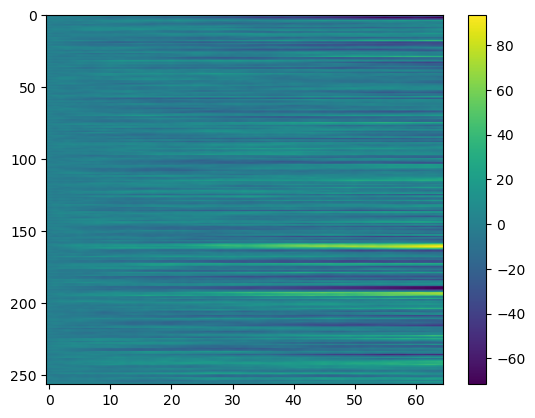

In [13]:

phases = dataset.phases
print(phases.shape)
phase = phases[0,0,:,:]
print(phase.shape)

plt.figure()
plt.imshow(phase, aspect='auto')
plt.colorbar()
plt.show()